In [24]:
# !wget https://pjreddie.com/media/files/yolov3.weights

In [25]:
### Import Libraries

import tensorflow as tf

import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle


import struct

from util.yolov3_util import decode_netout, WeightReader, correct_yolo_boxes, do_nms, make_yolov3_model

from tensorflow.keras.layers import Conv2D

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model

In [26]:
# Some basic parameters

inpDir = 'input' # location where input data is stored
outDir = 'output' # location to store outputs
mdlDir = 'models' # location to store outputs
imgDir = 'yolo_images'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
EPOCHS = 100 # number of cycles to run

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large'
         }

plt.rcParams.update(params) # update rcParams

In [27]:
# define the labels
'''labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
'''
labels = ["person", "bicycle", "car", "motorbike", "pottedplant"]

# define the expected input shape for the model
input_w, input_h = 416, 416

# Anchor Size
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.5 #0.7 # 0.3

nonmaxsup_threshold= 0.45 #0.45 #0.2

In [28]:
model = make_yolov3_model() # define the model

weight_reader = WeightReader('yolov3.weights') # load the model weights

weight_reader.load_weights(model) # set the model weights into the model


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) # Compile the model

# save the model to file
model.save('yolo3_model.keras')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [29]:
# load and prepare an image
def load_image_pixels(filename, shape):
    
    # load the image to get its shape
    image = tf.keras.preprocessing.image.load_img(filename)
    width, height = image.size
    
    # load the image with the required size (Should not we be better off loading once????)
    image = tf.keras.preprocessing.image.load_img(filename, target_size=shape)
    
    # convert to a 3D Numpy array. 
    image = tf.keras.preprocessing.image.img_to_array(image)
    
    # scale values to between 0 and 1
    image = image.astype('float32')
    image /= 255.0
    
    #print ('before expand', image.shape, 'max pixel value', image.max())
    
    # add a dimension so that we have one sample
    image = tf.expand_dims(image, 0)
    #print ('after expand', image.shape)
    
    return image, width, height

In [30]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    
    # iterate all boxes
    for box in boxes:
        
        # iteratare all possible labels
        for i in range(len(labels)):
            
            # check if the threshold for this label is high enough to be listed
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100) # don't break, many labels may trigger for one box
                
    return v_boxes, v_labels, v_scores

In [35]:
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    
    # load the image
    data = plt.imread(filename)
    
    # plot the image
    plt.imshow(data)
    
    # get the context for drawing boxes
    ax = plt.gca()

    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "{:s} ({:.0f}%)".format(v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='white')
        img_name = filename.split('/')[-1]      
        plt.savefig(img_name+"_yolo3.png")
    
    # show the plot
    plt.show()

In [36]:
# define our new photo
photo_filename = 'istockphoto-155287967-612x612.jpg'


# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

# make prediction
y_pred = model.predict(image)

# summarize the shape of the list of arrays
print([a.shape for a in y_pred])

boxes = list()
for i in range(len(y_pred)):
    # decode the output of the network
    boxes += decode_netout(y_pred[i][0], anchors[i], class_threshold, nonmaxsup_threshold, input_h, input_w)

# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

# suppress non-maximal boxes
do_nms(boxes, nonmaxsup_threshold)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# What did you find in the picture
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

1/1 [==============================] - 0s 471ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
car 98.64795207977295
car 98.92957806587219
car 99.60974454879761
car 98.4061062335968
car 99.66892004013062
car 55.28777837753296
car 60.623133182525635
car 58.59007239341736
car 89.88170623779297
car 61.97343468666077
car 83.74093174934387
car 76.66821479797363
car 96.7450201511383
car 89.31317925453186
car 77.51003503799438
car 96.43993377685547
car 94.30410265922546
car 87.47373819351196
car 56.737345457077026
car 84.41501259803772
car 94.70402002334595
car 81.53803944587708
car 88.0480170249939
car 76.19107365608215
car 86.06507778167725
car 95.88161706924438
car 97.81067967414856
car 97.44336009025574
car 86.50338053703308
car 98.73231649398804
car 94.55302953720093
car 98.36536645889282
car 77.25900411605835
car 99.47627782821655
car 99.45435523986816
car 96.0287868976593
car 51.207417249679565
car 74.07233715057373


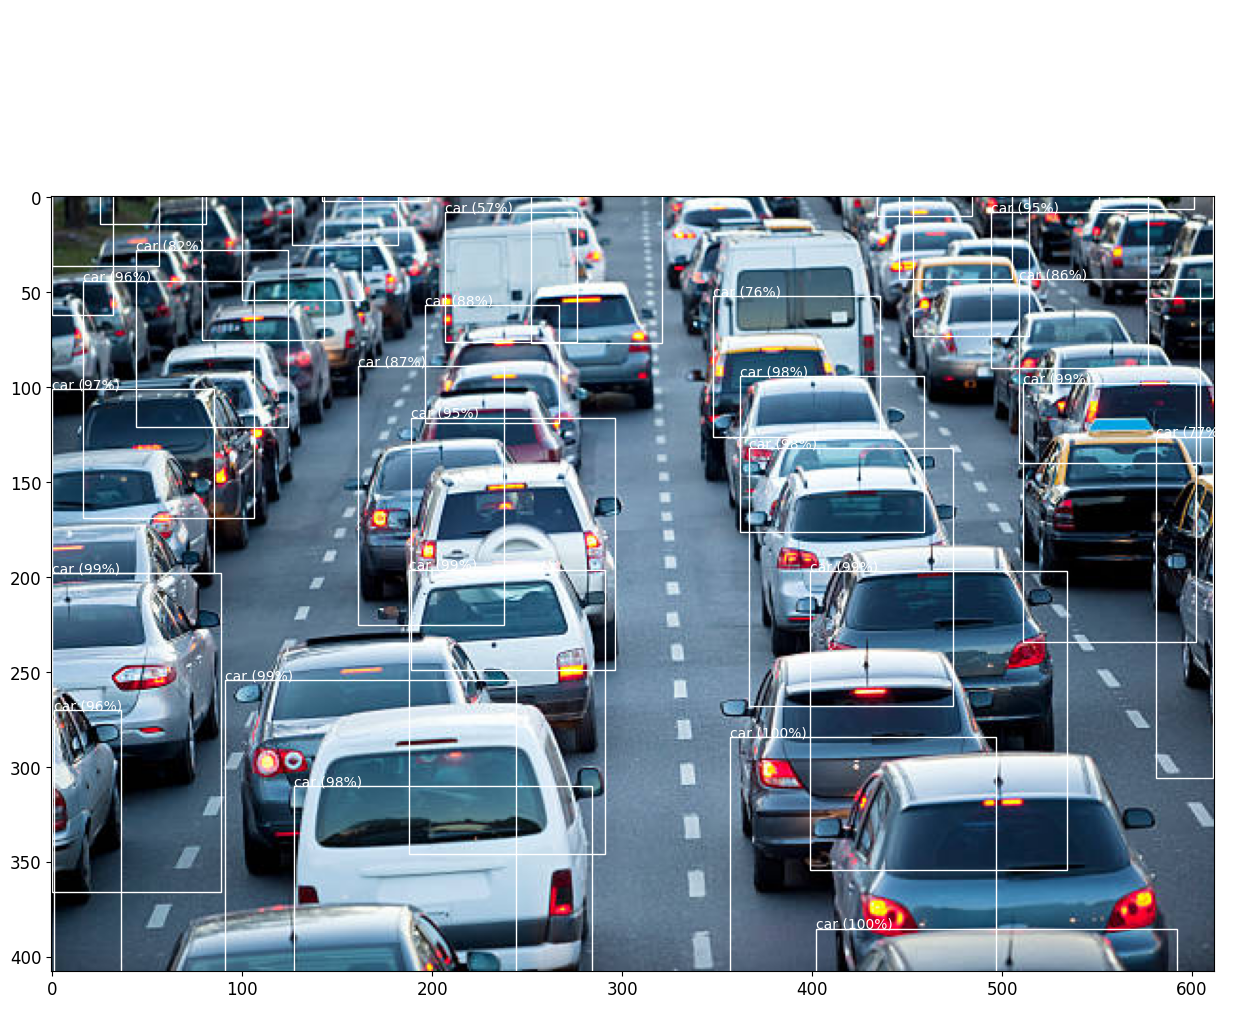

In [37]:
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

1/1 [==============================] - 0s 484ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 78.75478267669678
person 84.13887023925781
person 53.00236940383911
person 61.364805698394775
person 76.55982375144958
person 60.707759857177734
person 88.21695446968079
person 99.95885491371155
person 91.4313793182373
person 69.89883184432983


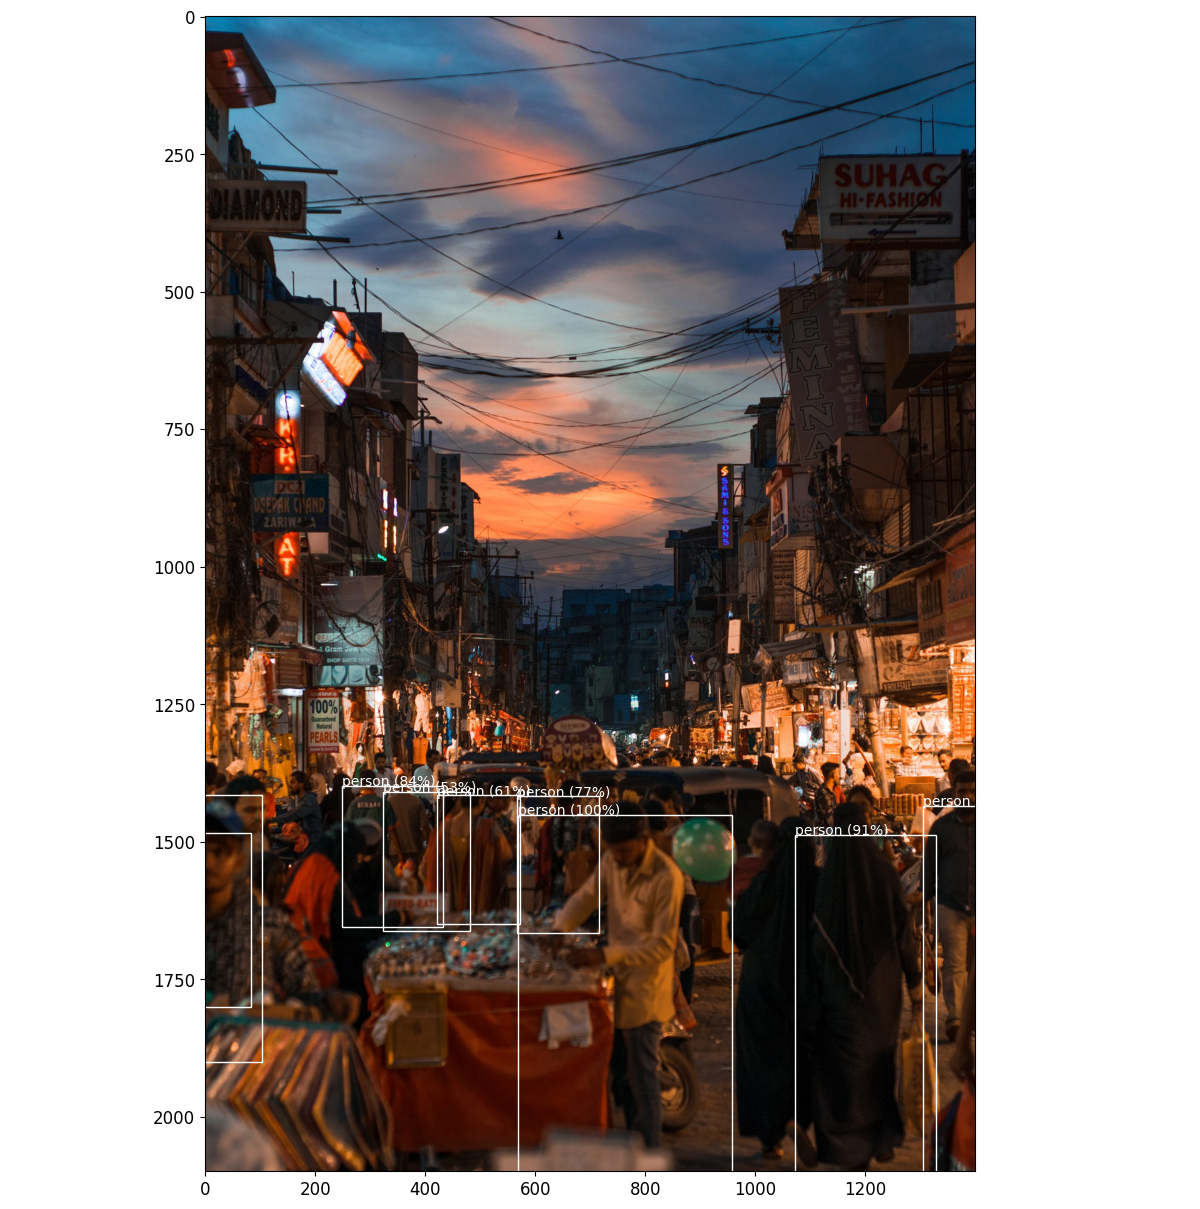

In [38]:
# define our new photo
photo_filename = '0_06qXUhbu0Nh2wnBV.jpg'


# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

# make prediction
y_pred = model.predict(image)

# summarize the shape of the list of arrays
print([a.shape for a in y_pred])

boxes = list()
for i in range(len(y_pred)):
    # decode the output of the network
    boxes += decode_netout(y_pred[i][0], anchors[i], class_threshold, nonmaxsup_threshold, input_h, input_w)

# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

# suppress non-maximal boxes
do_nms(boxes, nonmaxsup_threshold)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# What did you find in the picture
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

draw_boxes(photo_filename, v_boxes, v_labels, v_scores)